In [1]:
import pandas as pd
import numpy as np

from scipy.stats import chisquare
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import warnings, math
warnings.simplefilter("ignore")

In [2]:
# hello world
data = pd.read_csv('../loan_data_2007_2014.csv', low_memory=False)
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
def calculate_woe(df, feature, y):
    ''' calculates WoE and IV for each feature '''
    df = pd.concat([df[feature], y], axis=1)
    target = df.columns.values[1]
    
    # calculate number of occurences of the given bin (support)
    support = df.groupby(feature, as_index=False)[target].count()
    # calculate the proportion of positive occurences 
    n_pos = df.groupby(feature, as_index = False)[target].mean()
    # get dataframe of (binned_feature, support, n_pos)
    df = pd.concat([support, n_pos], axis=1).iloc[:, [0, 1, 3]]
    df.columns = [feature, 'support', 'pos%']
    df['pos%'] = df['pos%'].apply(lambda x: 1-x)
    # count of positive/negative occurences
    positive = df['pos%'] * df['support']
    negative = (1 - df['pos%']) * df['support']
    # calculate what percentage of total positives/negatives given feature bin has
    pos = positive / positive.sum(); neg = negative / negative.sum()
    # finally calculate WoE and sort dataframe by WoE for plotting
    df['WoE'] = np.log(pos / neg)
    df = df.sort_values([feature]).reset_index(drop=True)
    # calculate IV using WoE
    df['IV'] = abs(((pos - neg) * df['WoE']).sum())
    return df

def plot_woe(df):
    ''' plots support, WoE and IV of each feature '''
    plt.figure(figsize=(10, 5))
    plt.plot(df.iloc[:, 0].astype(str), df['WoE'], marker = 'o', color='black')
    plt.xlabel(df.columns[0])
    plt.ylabel('WoE')

In [4]:
# preprocess the target column
''' 
Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
'''

# following features will be labeled `1` to indicate "bad" loans
data['loan_status'] = data['loan_status'].replace(['Charged Off', 'Late (31-120 days)', 'Default',
                                                  'Does not meet the credit policy. Status:Charged Off'], 1)
# following features will be labeled `0` to indicate "good" loans
data['loan_status'] = data['loan_status'].replace(['Current', 'Fully Paid', 'In Grace Period', 'Late (16-30 days)',
                                                  'Does not meet the credit policy. Status:Fully Paid'], 0)


## Data Preprocessing

In [5]:
X_woe = pd.DataFrame()

### loan_amnt

,loan_amnt,support,pos%,WoE,IV
0,"(499.999, 8000.0]",125326,0.896095,0.056725,0.001849
1,"(8000.0, 12000.0]",108713,0.892166,0.015211,0.001849
2,"(12000.0, 20000.0]",134488,0.889090,-0.016360,0.001849
3,"(20000.0, 35000.0]",97758,0.884337,-0.063688,0.001849


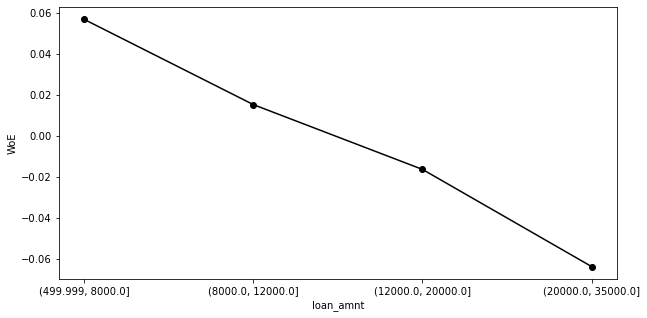

In [6]:
X_woe['loan_amnt'] = pd.qcut(data['loan_amnt'], 4)
df_temp = calculate_woe(X_woe, 'loan_amnt', data['loan_status'])
plot_woe(df_temp)
df_temp

### funded_amnt

,funded_amnt,support,pos%,WoE,IV
0,"(499.999, 8000.0]",125587,0.895984,0.055539,0.001668
1,"(8000.0, 12000.0]",108880,0.891927,0.012732,0.001668
2,"(12000.0, 20000.0]",134579,0.888957,-0.017709,0.001668
3,"(20000.0, 35000.0]",97239,0.884882,-0.058352,0.001668


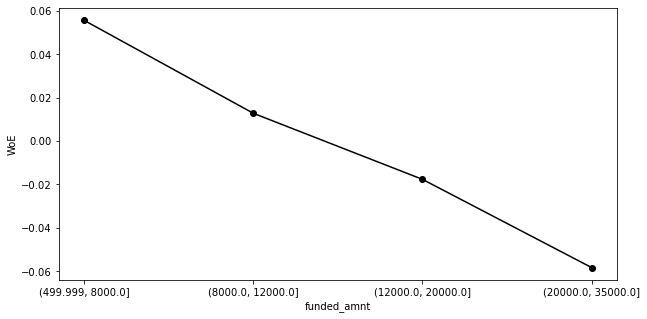

In [7]:
X_woe['funded_amnt'] = pd.qcut(data['funded_amnt'], 4)
df_temp = calculate_woe(X_woe, 'funded_amnt', data['loan_status'])
plot_woe(df_temp)
df_temp

### funded_amnt_inv

,funded_amnt_inv,support,pos%,WoE,IV
0,"(-35.0, 11666.667]",208389,0.891578,0.009115,0.00018
1,"(11666.667, 23333.333]",183004,0.890877,0.001884,0.00018
2,"(23333.333, 35000.0]",74892,0.887785,-0.029530,0.00018


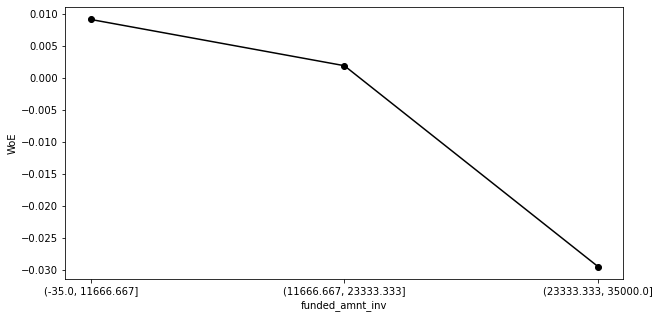

In [8]:
X_woe['funded_amnt_inv'] = pd.cut(data['funded_amnt_inv'], 3)
df_temp = calculate_woe(X_woe, 'funded_amnt_inv', data['loan_status'])
plot_woe(df_temp)
df_temp

### term

In [9]:
data['term'].value_counts()

 36 months    337953
 60 months    128332
Name: term, dtype: int64

,term,support,pos%,WoE,IV
0,36 months,337953,0.902915,0.132203,0.03886
1,60 months,128332,0.858508,-0.294894,0.03886


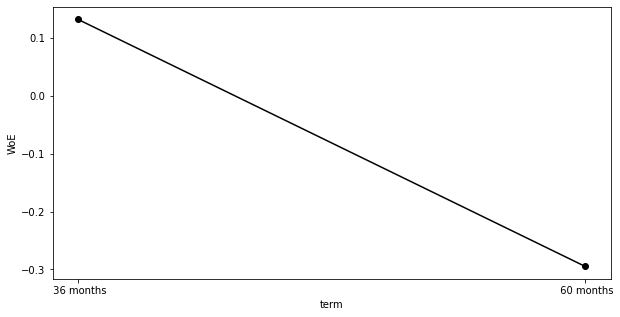

In [10]:
df_temp = calculate_woe(data, 'term', data['loan_status'])
plot_woe(df_temp)
df_temp

### int_rate

,int_rate,support,pos%,WoE,IV
0,"(5.399, 12.3]",172212,0.943012,0.708396,0.241821
1,"(12.3, 19.18]",239482,0.875431,-0.147986,0.241821
2,"(19.18, 26.06]",54591,0.792603,-0.757155,0.241821


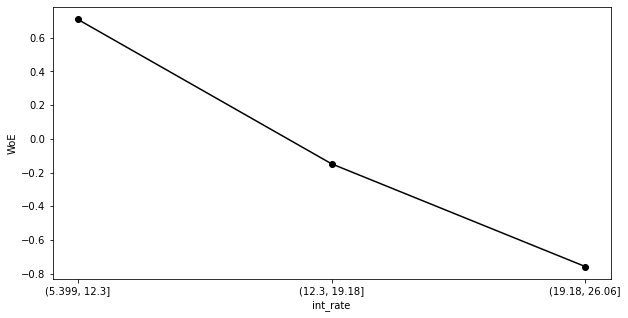

In [11]:
X_woe['int_rate'] = pd.cut(data['int_rate'], 3)
df_temp = calculate_woe(X_woe, 'int_rate', data['loan_status'])
plot_woe(df_temp)
df_temp

### installment

,installment,support,pos%,WoE,IV
0,"(15.669, 300.39]",155497,0.896557,0.061702,0.002334
1,"(300.39, 495.35]",155363,0.890463,-0.002365,0.002334
2,"(495.35, 1409.99]",155425,0.885057,-0.056627,0.002334


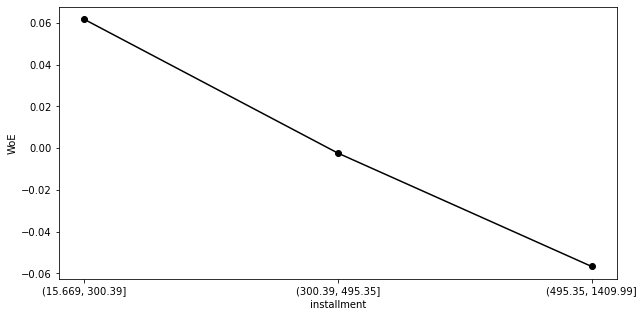

In [12]:
X_woe['installment'] = pd.qcut(data['installment'], 3)
df_temp = calculate_woe(X_woe, 'installment', data['loan_status'])
plot_woe(df_temp)
df_temp

### grade

,grade,support,pos%,WoE,IV
0,A,74867,0.961305,1.114730,0.290782
1,B,136929,0.921426,0.364043,0.290782
2,C,125293,0.885197,-0.055251,0.290782
3,D,76888,0.845906,-0.395001,0.290782
4,E,35757,0.805241,-0.678466,0.290782
5,F,13229,0.758712,-0.952214,0.290782
6,G,3322,0.721854,-1.144166,0.290782


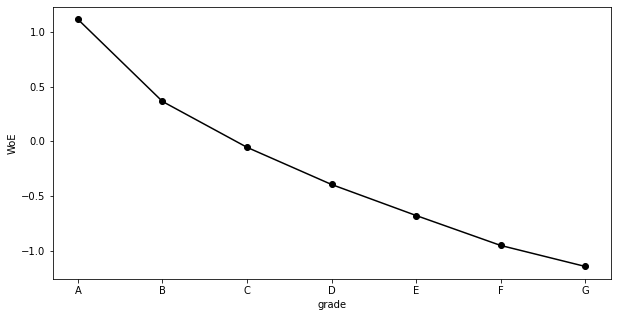

In [13]:
df_temp = calculate_woe(data, 'grade', data['loan_status'])
plot_woe(df_temp)
df_temp

### sub_grade

,sub_grade,support,pos%,WoE,IV
0,A1,10541,0.980837,1.837567,0.31518
1,A2,10956,0.971431,1.428610,0.31518
2,A3,12568,0.964990,1.218653,0.31518
3,A4,19045,0.955684,0.973235,0.31518
4,A5,21757,0.949533,0.836817,0.31518
5,B1,22876,0.940287,0.658787,0.31518
6,B2,26610,0.931567,0.513170,0.31518
7,B3,31686,0.921038,0.358686,0.31518
8,B4,30505,0.912998,0.252957,0.31518
9,B5,25252,0.904324,0.148381,0.31518


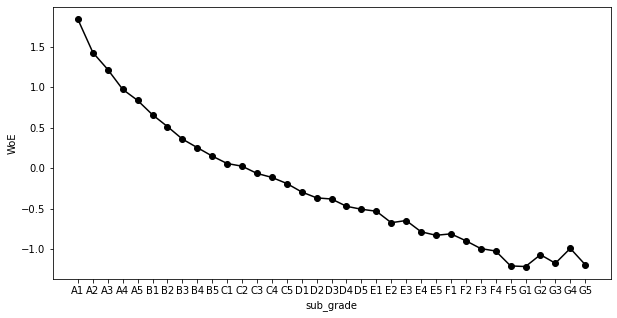

In [14]:
df_temp = calculate_woe(data, 'sub_grade', data['loan_status'])
plot_woe(df_temp)
df_temp

,sub_grade,support,pos%,WoE,IV
0,"(-0.001, 18.0]",109935,0.816237,-0.606787,0.282049
1,"(18.0, 22.0]",90861,0.874027,-0.160797,0.282049
2,"(22.0, 26.0]",109450,0.901928,0.120987,0.282049
3,"(26.0, 29.0]",81172,0.929914,0.487529,0.282049
4,"(29.0, 34.0]",74867,0.961305,1.114730,0.282049


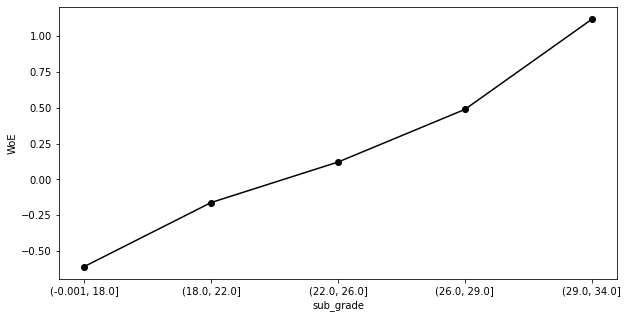

In [15]:
# since grades are ordinal data (we can compare them), its best to use a label encoder here. Otherwise we have too many features
grades = list(data['sub_grade'].unique())
grades.sort(reverse=True) # sorts grades as [G5, G4, ... A2, A1]
grades_map = dict(zip(grades, list(range(len(grades))))) # get dict of corresponding indices
data['sub_grade'] = data['sub_grade'].apply(lambda x: grades_map[x])
# plot the results
X_woe['sub_grade'] = pd.qcut(data['sub_grade'], 5)
df_temp = calculate_woe(X_woe, 'sub_grade', data['loan_status'])
plot_woe(df_temp)
df_temp

We have effectively reduced number of features from 35 to 10 while also increasing the IV

### emp_length

In [16]:
# lots of nan, best strategy would be to make it a separate category
data['emp_length'] = data['emp_length'].fillna('NaN')

,emp_length,support,pos%,WoE,IV
0,1 year,29622,0.888124,-0.026127,0.007082
1,10+ years,150049,0.900353,0.103304,0.007082
2,2 years,41373,0.890242,-0.004624,0.007082
3,3 years,36596,0.890480,-0.002192,0.007082
4,4 years,28023,0.890411,-0.002893,0.007082
5,5 years,30774,0.885033,-0.056866,0.007082
6,6 years,26112,0.882889,-0.077766,0.007082
7,7 years,26180,0.888655,-0.020764,0.007082
8,8 years,22395,0.889931,-0.007810,0.007082
9,9 years,17888,0.887914,-0.028239,0.007082


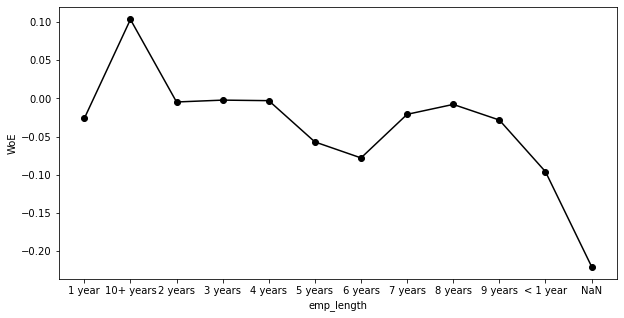

In [17]:
df_temp = calculate_woe(data, 'emp_length', data['loan_status'])
plot_woe(df_temp)
df_temp

In [18]:
# again, we have an ordinal feature, best to label encode it
emp_len = ['NaN', '< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', 
           '6 years', '7 years', '8 years', '9 years', '10+ years']
emp_len_map = dict(zip(emp_len, range(len(emp_len))))
data['emp_length'] = data['emp_length'].apply(lambda x: emp_len_map[x])

,emp_length,support,pos%,WoE,IV
0,"(-0.011, 2.75]",86895,0.880143,-0.104062,0.004942
1,"(2.75, 5.5]",105992,0.890369,-0.003327,0.004942
2,"(5.5, 8.25]",83066,0.885501,-0.052260,0.004942
3,"(8.25, 11.0]",190332,0.897957,0.076887,0.004942


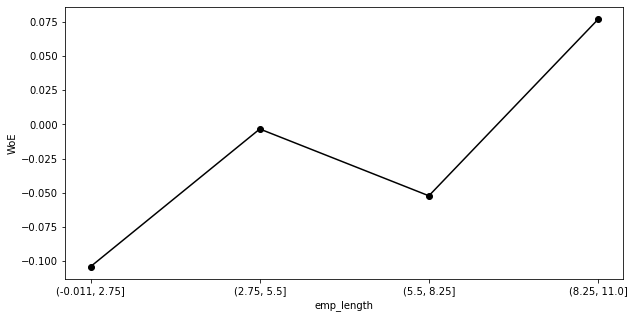

In [19]:
# plot the results
X_woe['emp_length'] = pd.cut(data['emp_length'], 4)
df_temp = calculate_woe(X_woe, 'emp_length', data['loan_status'])
plot_woe(df_temp)
df_temp

### home_ownership

,home_ownership,support,pos%,WoE,IV
0,MORTGAGE,236108,0.903917,0.143679,0.021187
1,OWN,41704,0.891737,0.010764,0.021187
2,RENT,188473,0.873897,-0.161980,0.021187


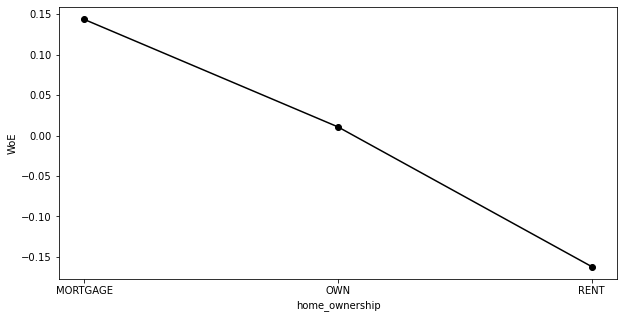

In [20]:
# features ANY/NONE/OTHER contain too few samples, therefore we aggregate them with mode - MORTGAGE
data['home_ownership'] = data['home_ownership'].replace(['ANY', 'NONE', 'OTHER'], 'MORTGAGE')
df_temp = calculate_woe(data, 'home_ownership', data['loan_status'])
plot_woe(df_temp)
df_temp

### annual_inc

In [21]:
data['annual_inc'] = data['annual_inc'].fillna(data['annual_inc'].median())

,annual_inc,support,pos%,WoE,IV
0,"(1895.999, 50000.0]",157715,0.865390,-0.237045,0.047585
1,"(50000.0, 78000.0]",153613,0.890406,-0.002945,0.047585
2,"(78000.0, 7500000.0]",154957,0.916732,0.300903,0.047585


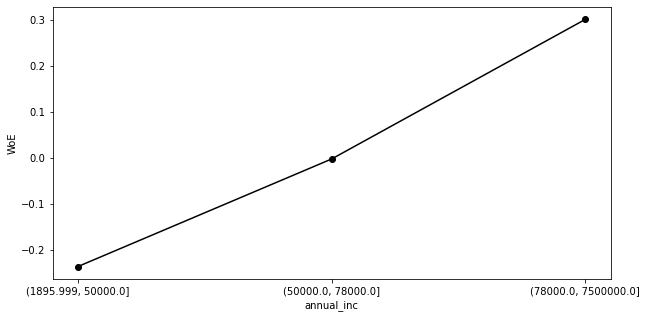

In [22]:
X_woe['annual_inc'] = pd.qcut(data['annual_inc'], 3)
df_temp = calculate_woe(X_woe, 'annual_inc', data['loan_status'])
plot_woe(df_temp)
df_temp

### verification_status

,verification_status,support,pos%,WoE,IV
0,Not Verified,148237,0.905921,0.166972,0.020831
1,Source Verified,149993,0.895882,0.054438,0.020831
2,Verified,168055,0.872631,-0.173420,0.020831


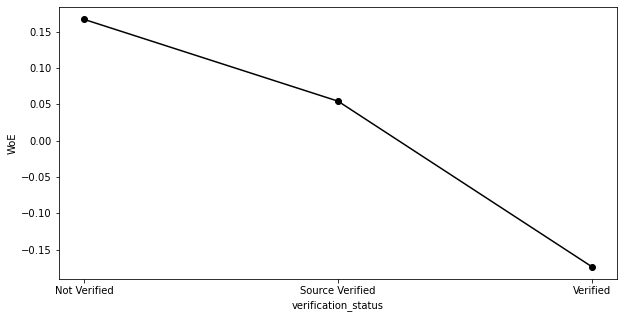

In [23]:
df_temp = calculate_woe(data, 'verification_status', data['loan_status'])
plot_woe(df_temp)
df_temp

### issue_d

In [24]:
# based on domain knowledge, its best to omit this feature, banks to not give any preference to any specific issue dates
print(data['issue_d'].describe())
print(data['issue_d'].isnull().sum())

count     466285
unique        91
top       Oct-14
freq       38782
Name: issue_d, dtype: object
0


### pymnt_plan

In [25]:
# omit this feature, features with value `y` are encountered very rarely
print(data['pymnt_plan'].value_counts())
print(data['pymnt_plan'].isnull().sum())

n    466276
y         9
Name: pymnt_plan, dtype: int64
0


### purpose

In [26]:
data['purpose'].value_counts()

debt_consolidation    274195
credit_card           104157
home_improvement       26537
other                  23690
major_purchase          9828
small_business          7013
car                     5397
medical                 4602
moving                  2994
vacation                2487
wedding                 2343
house                   2269
educational              422
renewable_energy         351
Name: purpose, dtype: int64

,purpose,support,pos%,WoE,IV
0,credit_card,104157,0.913774,0.262772,0.024279
1,debt_consolidation,274195,0.886690,-0.040475,0.024279
2,home_improvement,26537,0.901835,0.119940,0.024279
3,other,61396,0.864600,-0.243808,0.024279


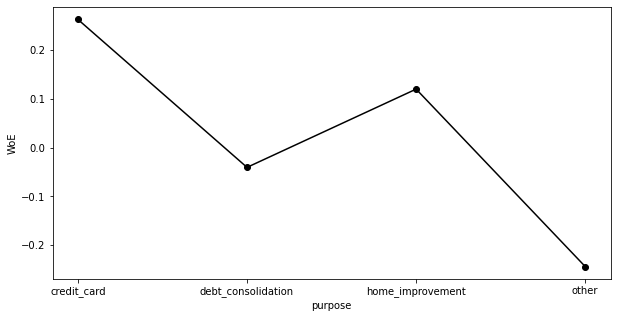

In [27]:
data['purpose'] = data['purpose'].apply(lambda x: x if x in ['debt_consolidation', 'credit_card', 'home_improvement'] else 'other')
df_temp = calculate_woe(data, 'purpose', data['loan_status'])
plot_woe(df_temp)
df_temp

,purpose,support,pos%,WoE,IV
0,credit_card,104157,0.913774,0.262772,0.024279
1,debt_consolidation,274195,0.886690,-0.040475,0.024279
2,home_improvement,26537,0.901835,0.119940,0.024279
3,other,61396,0.864600,-0.243808,0.024279


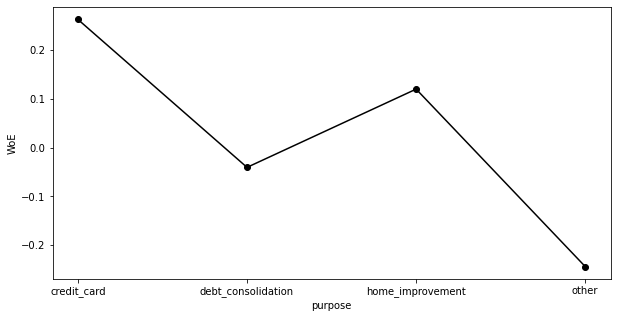

In [28]:
data['purpose'] = data['purpose'].replace(['educational', 'renewable_energy', 'small_business', 'moving', 'house', 'medical',
                                      'wedding', 'vacation', 'major_purchase', 'car'], 'other')
df_temp = calculate_woe(data, 'purpose', data['loan_status'])
plot_woe(df_temp)
df_temp

-----------------------------------------------------------------------

# dti

,dti,support,pos%,WoE,IV
0,"(-0.001, 11.36]",116632,0.909785,0.213164,0.024723
1,"(11.36, 16.87]",116620,0.899906,0.098333,0.024723
2,"(16.87, 22.78]",116511,0.883041,-0.076295,0.024723
3,"(22.78, 39.99]",116522,0.870016,-0.196744,0.024723


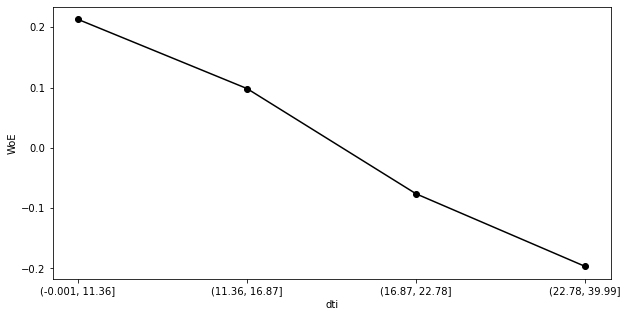

In [29]:
X_woe['dti'] = pd.qcut(data['dti'], 4)
df_temp = calculate_woe(X_woe, 'dti', data['loan_status'])
plot_woe(df_temp)
df_temp

# delinq_2yrs

In [30]:
data['delinq_2yrs'].describe()

count    466256.000000
mean          0.284678
std           0.797365
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          29.000000
Name: delinq_2yrs, dtype: float64

In [31]:
#as there are only 29 null values we can replace them with the median of the data
data['delinq_2yrs'] = data['delinq_2yrs'].fillna(data['delinq_2yrs'].median())

In [32]:
data['delinq_2yrs'] = data['delinq_2yrs'].apply(lambda x: 2 if x>=2 else x)

,delinq_2yrs,support,pos%,WoE,IV
0,0.0,382983,0.890588,-0.001084,0.000093
1,1.0,56224,0.892679,0.020562,0.000093
2,2.0,27078,0.888064,-0.026726,0.000093


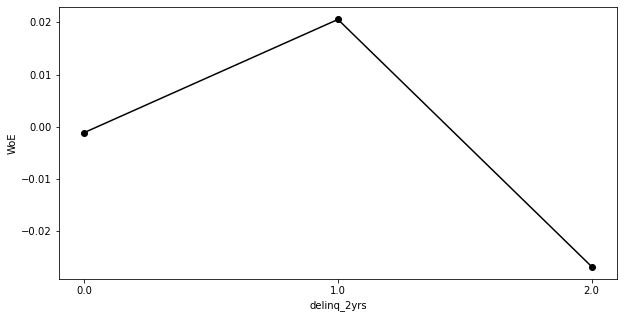

In [33]:
df_temp = calculate_woe(data, 'delinq_2yrs', data['loan_status'])
plot_woe(df_temp)
df_temp

# earliest_cr_line

In [34]:
# Date features in this dataset have inconsistent formatting, therefore they cannot be processed properly

# inq_last_6mths

In [35]:
data['inq_last_6mths'] = data['inq_last_6mths'].apply(lambda x: 2 if x>1 else x)

In [36]:
# as there are only 29 null values we can replace them with the median of the data
data['inq_last_6mths'] = data['inq_last_6mths'].fillna(data['inq_last_6mths'].median())

,inq_last_6mths,support,pos%,WoE,IV
0,"(-0.002, 0.667]",241527,0.908735,0.200440,0.046716
1,"(0.667, 1.333]",130148,0.884439,-0.062687,0.046716
2,"(1.333, 2.0]",94610,0.853240,-0.337605,0.046716


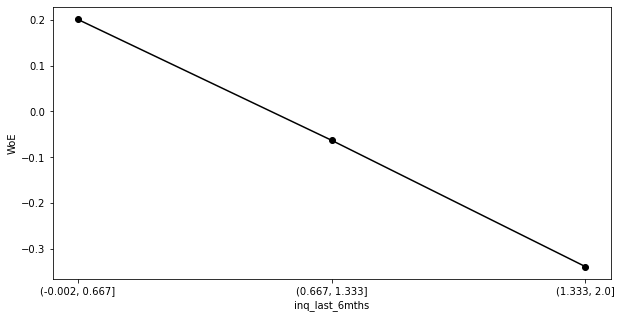

In [37]:
X_woe['inq_last_6mths'] = pd.cut(data['inq_last_6mths'], 3)
df_temp = calculate_woe(X_woe, 'inq_last_6mths', data['loan_status'])
plot_woe(df_temp)
df_temp

# mths_since_last_delinq

In [38]:
# there are lots of nan, best thing to do would be to make it a separate category
data['mths_since_last_delinq'] = data['mths_since_last_delinq'].replace(['NaN'],0)

In [39]:
data['mths_since_last_delinq'] = data['mths_since_last_delinq'].apply(lambda x: 28 if x>0 else x)

In [40]:
#as IV value is less and also more than 50 percent of data is not given in the data set
#we can ignore this 'mths_since_last_delinq' column

# mths_since_last_record

In [41]:
data['mths_since_last_record'].isnull().sum()

403647

In [42]:
# nearly 90 percent of data is Nan. so we can safely ignore this column

# open_acc

In [43]:
#as there are only 29 null values we can replace them with the median of the data. also mode is almost same as mean here.
data['open_acc'] = data['open_acc'].fillna(data['open_acc'].median())

,open_acc,support,pos%,WoE,IV
0,"(-0.001, 10.0]",238463,0.889639,-0.010785,0.000123
1,"(10.0, 84.0]",227822,0.891797,0.011386,0.000123


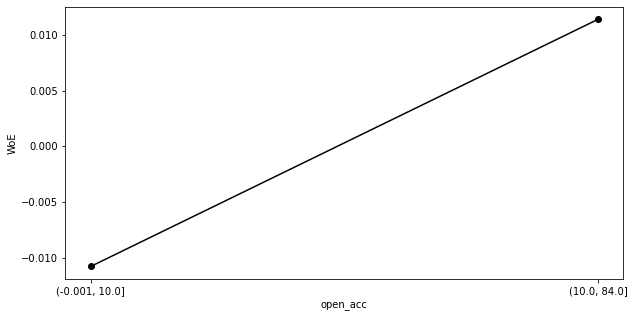

In [44]:
X_woe['open_acc'] = pd.qcut(data['open_acc'], 2)
df_temp = calculate_woe(X_woe, 'open_acc', data['loan_status'])
plot_woe(df_temp)
df_temp

In [45]:
#IV value is very low. so we can ignore this column

# pub_rec

In [46]:
data['pub_rec'] = data['pub_rec'].apply(lambda x: 1 if x>0 else x)

In [47]:
#as there are only 29 null values we can replace them with the median of the data
data['pub_rec'] = data['pub_rec'].fillna(data['pub_rec'].median())

,pub_rec,support,pos%,WoE,IV
0,0.0,404922,0.889789,-0.009260,0.000582
1,1.0,61363,0.896664,0.062853,0.000582


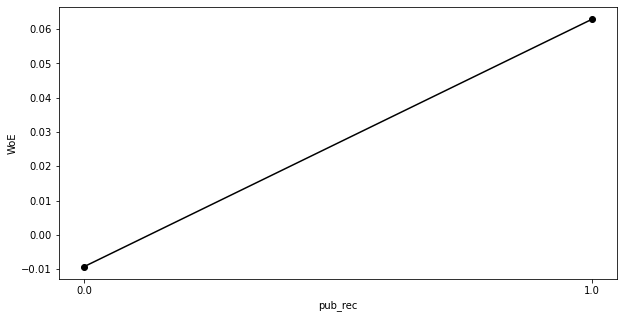

In [48]:
df_temp = calculate_woe(data, 'pub_rec', data['loan_status'])
plot_woe(df_temp)
df_temp

### revol_bal

,revol_bal,support,pos%,WoE,IV
0,"(-0.001, 5442.0]",93275,0.887044,-0.036951,0.004783
1,"(5442.0, 9451.0]",93242,0.886146,-0.045882,0.004783
2,"(9451.0, 14527.0]",93261,0.887027,-0.037120,0.004783
3,"(14527.0, 23168.0]",93259,0.889555,-0.011641,0.004783
4,"(23168.0, 2568995.0]",93248,0.903698,0.141158,0.004783


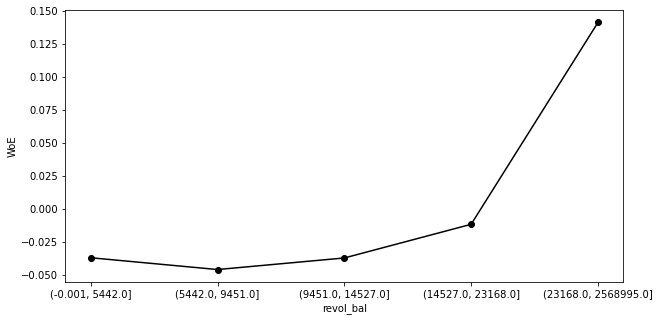

In [49]:
X_woe['revol_bal'] = pd.qcut(data['revol_bal'], 5)
df_temp = calculate_woe(X_woe, 'revol_bal', data['loan_status'])
plot_woe(df_temp)
df_temp

### revol_util

In [50]:
data['revol_util'] = data['revol_util'].fillna(data['revol_util'].median())

,revol_util,support,pos%,WoE,IV
0,"(-0.001, 39.2]",116597,0.911627,0.235823,0.025596
1,"(39.2, 57.6]",117255,0.896636,0.062544,0.025596
2,"(57.6, 74.7]",116094,0.885136,-0.055850,0.025596
3,"(74.7, 892.3]",116339,0.869270,-0.203325,0.025596


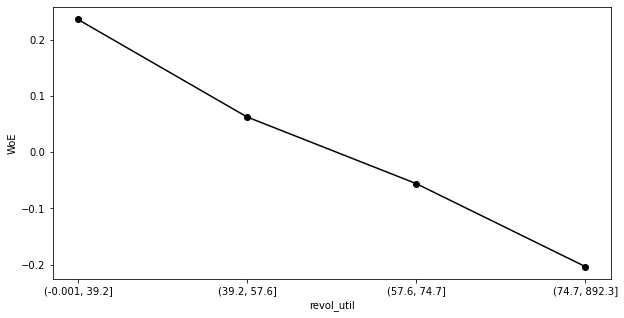

In [51]:
X_woe['revol_util'] = pd.qcut(data['revol_util'], 4)
df_temp = calculate_woe(X_woe, 'revol_util', data['loan_status'])
plot_woe(df_temp)
df_temp

### total_acc

,total_acc,support,pos%,WoE,IV
0,"(0.999, 17.0]",132281,0.879930,-0.106074,0.005802
1,"(17.0, 23.0]",101106,0.889789,-0.009253,0.005802
2,"(23.0, 32.0]",123799,0.895605,0.051477,0.005802
3,"(32.0, 156.0]",109070,0.899010,0.088430,0.005802


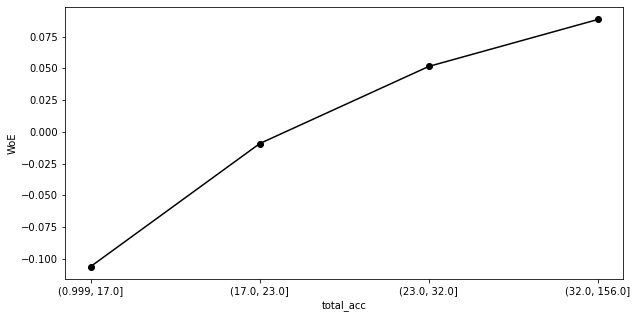

In [52]:
X_woe['total_acc'] = pd.qcut(data['total_acc'], 4)
df_temp = calculate_woe(X_woe, 'total_acc', data['loan_status'])
plot_woe(df_temp)
df_temp
# feature can be discarded as IV is Too Low 

### initial_list_status

,initial_list_status,support,pos%,WoE,IV
0,f,303005,0.879692,-0.108330,0.024801
1,w,163280,0.911110,0.229417,0.024801


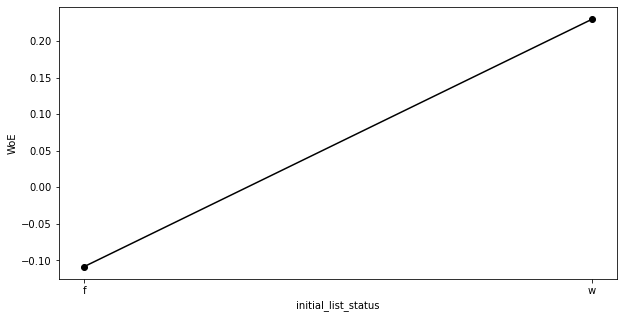

In [53]:
df_temp = calculate_woe(data, 'initial_list_status', data['loan_status'])
plot_woe(df_temp)
df_temp

### out_prncp

In [54]:
data['out_prncp'] = data['out_prncp'].apply(lambda x: 0 if x < 442 else 1)

,out_prncp,support,pos%,WoE,IV
0,0,233147,0.814267,-0.619863,0.747155
1,1,233138,0.967122,1.283692,0.747155


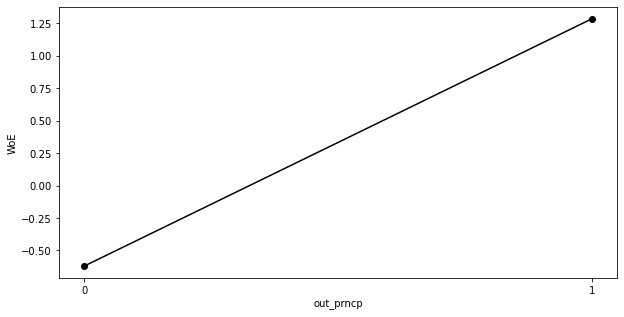

In [55]:
df_temp = calculate_woe(data, 'out_prncp', data['loan_status'])
plot_woe(df_temp)
df_temp

### out_prncp_inv

In [56]:
# is inverse of `out_prncp` feature, redundant

### total_pymnt

,total_pymnt,support,pos%,WoE,IV
0,"(-0.001, 5552.125]",116572,0.776876,-0.850290,0.517973
1,"(5552.125, 9419.251]",116571,0.892623,0.019978,0.517973
2,"(9419.251, 15308.158]",116571,0.929614,0.482927,0.517973
3,"(15308.158, 57777.58]",116571,0.963662,1.180022,0.517973


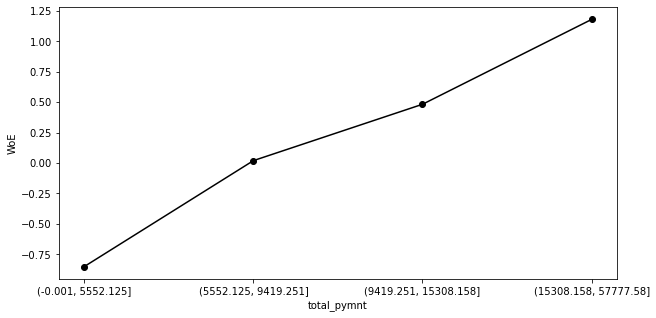

In [57]:
X_woe['total_pymnt'] = pd.qcut(data['total_pymnt'], 4, duplicates='drop')
df_temp = calculate_woe(X_woe, 'total_pymnt', data['loan_status'])
plot_woe(df_temp)
df_temp

## total_rec_prncp

,total_rec_prncp,support,pos%,WoE,IV
0,"(-0.001, 3708.56]",116572,0.724582,-1.130538,1.097607
1,"(3708.56, 6817.76]",116572,0.902404,0.126378,1.097607
2,"(6817.76, 12000.0]",123921,0.953809,0.929841,1.097607
3,"(12000.0, 35000.03]",109220,0.983877,2.013383,1.097607


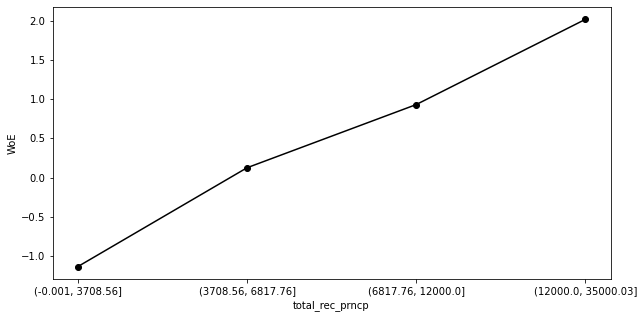

In [58]:
X_woe['total_rec_prncp'] = pd.qcut(data['total_rec_prncp'], 4)
df_temp = calculate_woe(X_woe, 'total_rec_prncp', data['loan_status'])
plot_woe(df_temp)
df_temp

## total_rec_int

,total_rec_int,support,pos%,WoE,IV
0,"(-0.001, 1818.88]",233149,0.881634,-0.089852,0.008678
1,"(1818.88, 24205.62]",233136,0.899754,0.096648,0.008678


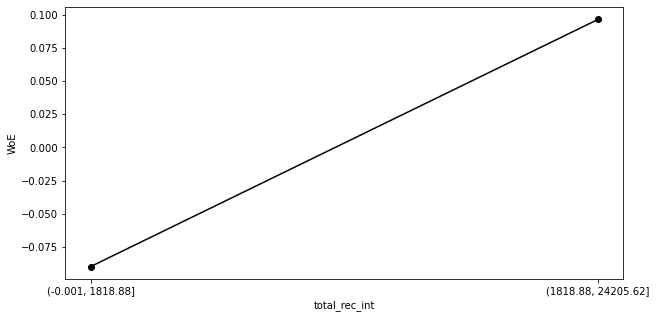

In [59]:
X_woe['total_rec_int'] = pd.qcut(data['total_rec_int'], 2)
df_temp = calculate_woe(X_woe, 'total_rec_int', data['loan_status'])
plot_woe(df_temp)
df_temp

## total_rec_late_fee

,total_rec_late_fee,support,pos%,WoE,IV
0,"(-0.359, 179.34]",466270,0.890707,0.000140,0.000313
1,"(179.34, 358.68]",15,0.466667,-2.231375,0.000313


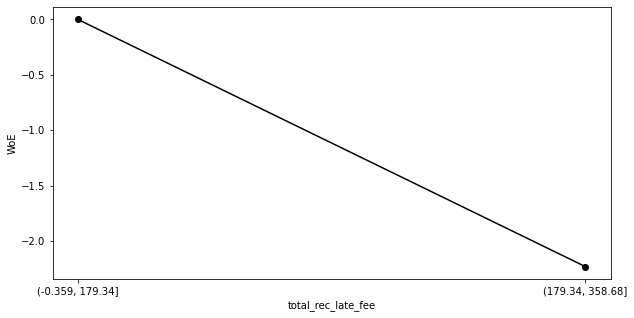

In [60]:
X_woe['total_rec_late_fee'] = pd.cut(data['total_rec_late_fee'], 2, duplicates='drop')
df_temp = calculate_woe(X_woe, 'total_rec_late_fee', data['loan_status'])
plot_woe(df_temp)
df_temp

## recoveries

,recoveries,support,pos%,WoE,IV
0,"(-33.52, 11173.423]",466180,0.890894,0.002062,inf
1,"(11173.423, 22346.847]",93,0.000000,-inf,inf
2,"(22346.847, 33520.27]",12,0.000000,-inf,inf


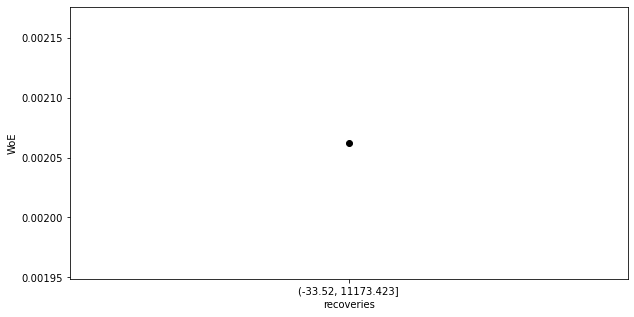

In [61]:
X_woe['recoveries'] = pd.cut(data['recoveries'], 3)
df_temp = calculate_woe(X_woe, 'recoveries', data['loan_status'])
plot_woe(df_temp)
df_temp
#IV values is NaN and almost all the values are 0's.

## collection_recovery_fee

,collection_recovery_fee,support,pos%,WoE,IV
0,"(-7.002, 3501.095]",466252,0.890757,0.000648,inf
1,"(3501.095, 7002.19]",33,0.000000,-inf,inf


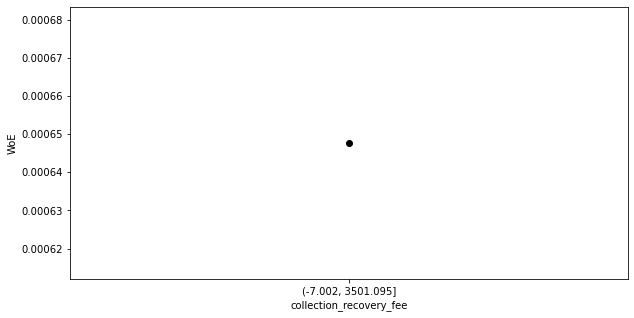

In [62]:
X_woe['collection_recovery_fee'] = pd.cut(data['collection_recovery_fee'], 2)
df_temp = calculate_woe(X_woe, 'collection_recovery_fee', data['loan_status'])
plot_woe(df_temp)
df_temp

## last_pymnt_amnt

,last_pymnt_amnt,support,pos%,WoE,IV
0,"(-0.001, 545.96]",233174,0.842307,-0.422353,0.263464
1,"(545.96, 36234.44]",233111,0.939093,0.637729,0.263464


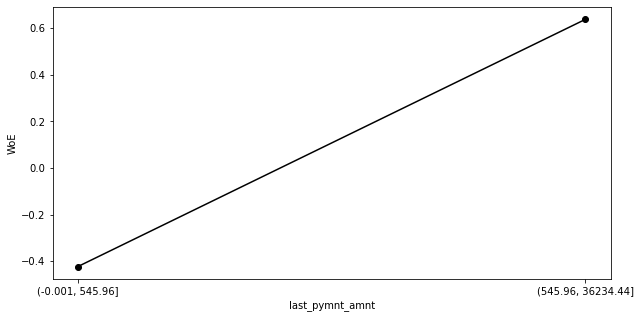

In [63]:
X_woe['last_pymnt_amnt'] = pd.qcut(data['last_pymnt_amnt'], 2)
df_temp = calculate_woe(X_woe, 'last_pymnt_amnt', data['loan_status'])
plot_woe(df_temp)
df_temp

,collections_12_mths_ex_med,support,pos%,WoE,IV
0,"(-0.02, 6.667]",466138,0.890719,-0.000005,inf
1,"(6.667, 13.333]",0,NaN,NaN,inf
2,"(13.333, 20.0]",2,1.000000,inf,inf


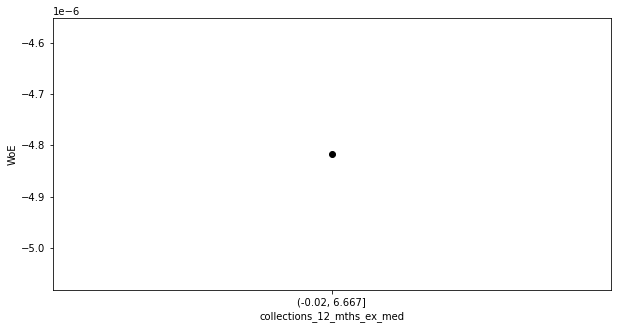

In [64]:
X_woe['collections_12_mths_ex_med'] = pd.cut(data['collections_12_mths_ex_med'], 3)
df_temp = calculate_woe(X_woe, 'collections_12_mths_ex_med', data['loan_status'])
plot_woe(df_temp)
df_temp
#IV values is negligible and almost all the values are 0's.

## Data transformation

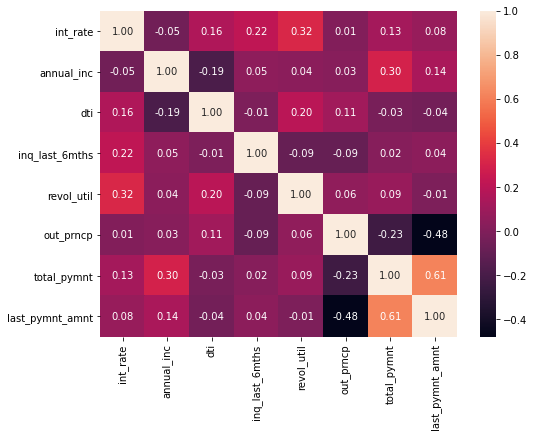

term : grade -> 0.0
term : verification_status -> 0.0
term : purpose -> 0.0
term : home_ownership -> 0.0
term : initial_list_status -> 0.0
grade : verification_status -> 0.0
grade : purpose -> 0.0
grade : home_ownership -> 0.0
grade : initial_list_status -> 1.6747217714055217e-160
verification_status : purpose -> 0.0
verification_status : home_ownership -> 0.0
verification_status : initial_list_status -> 0.0
purpose : home_ownership -> 0.0
purpose : initial_list_status -> 0.0
home_ownership : initial_list_status -> 1.3087933455700188e-87


,"int_rate:(5.399, 12.3]","int_rate:(12.3, 19.18]","int_rate:(19.18, 26.06]","annual_inc:(1895.999, 50000.0]","annual_inc:(50000.0, 78000.0]","annual_inc:(78000.0, 7500000.0]","dti:(-0.001, 11.36]","dti:(11.36, 16.87]","dti:(16.87, 22.78]","dti:(22.78, 39.99]",...,verification_status:Verified,purpose:credit_card,purpose:debt_consolidation,purpose:home_improvement,purpose:other,home_ownership:MORTGAGE,home_ownership:OWN,home_ownership:RENT,initial_list_status:f,initial_list_status:w
0,1,0,0,1,0,0,0,0,0,1,...,1,1,0,0,0,0,0,1,1,0
1,0,1,0,1,0,0,1,0,0,0,...,0,0,0,0,1,0,0,1,1,0
2,0,1,0,1,0,0,1,0,0,0,...,0,0,0,0,1,0,0,1,1,0
3,0,1,0,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,1,0
4,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466280,0,1,0,0,0,1,0,0,1,0,...,0,0,1,0,0,1,0,0,0,1
466281,0,0,1,0,1,0,0,0,1,0,...,1,0,1,0,0,1,0,0,1,0
466282,0,1,0,1,0,0,0,0,0,1,...,1,0,1,0,0,1,0,0,1,0
466283,1,0,0,0,0,1,1,0,0,0,...,1,1,0,0,0,0,1,0,0,1


In [78]:
categoric = ['term', 'grade', 'verification_status', 'purpose', 'home_ownership', 'initial_list_status']
numeric = ['int_rate', 'sub_grade', 'annual_inc', 'dti', 'inq_last_6mths', 'revol_util', 'out_prncp', 'total_pymnt',
          'total_rec_prncp', 'last_pymnt_amnt', 'out_prncp_inv']

df = data[categoric+numeric]

# based on correlation matrix we can exclude features 'sub_grade', 'total_rec_prncp', 'out_prncp_inv'
df = df.drop(['sub_grade', 'total_rec_prncp', 'out_prncp_inv'], axis=1)
numeric = list(filter(lambda x: x not in set(['sub_grade', 'total_rec_prncp', 'out_prncp_inv']), numeric))

plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, fmt='.2f')
plt.show()

# numeric columns are discretized by binning
df.loc[:, 'int_rate'] = pd.cut(df['int_rate'], 3).astype('str')
df.loc[:, 'annual_inc'] = pd.qcut(df['annual_inc'], 3).astype('str')
df.loc[:, 'dti'] = pd.qcut(df['dti'], 4).astype('str')
df.loc[:, 'inq_last_6mths'] = pd.cut(df['inq_last_6mths'], 3).astype('str')
df.loc[:, 'revol_util'] = pd.qcut(df['revol_util'], 4).astype('str')
df.loc[:, 'total_pymnt'] = pd.qcut(df['total_pymnt'], 4, duplicates='drop').astype('str')
df.loc[:, 'last_pymnt_amnt'] = pd.qcut(df['last_pymnt_amnt'], 2).astype('str')
df['out_prncp'] = df['out_prncp'].astype('str')

# iterate over all columns
for i, c1 in enumerate(categoric):
    for j in range(i+1, len(categoric)):
        c2 = categoric[j]
        # obtain observation matrix
        observation = pd.crosstab(data[c1], data[c2])
        # distribution of features `c2`
        c2_dist = [x / len(data[c2]) for x in data[c2].value_counts()]
        # expected values for c1 based on distribution of c2
        expected = [[len(data[data[c1]==x]) * d for d in c2_dist] for x in observation.index]
        # chi squared p value based on observed/expected values
        chi_res = list(chisquare(observation.values.flatten(), np.array(expected).flatten()))
        print(f'{c1} : {c2} -> {chi_res[1]}')

for col in numeric+categoric:
    df[col] = df[col].apply(lambda x: col+':'+x)

# one-hot-encode all features
for col in numeric+categoric:
    df = pd.concat([df,  pd.get_dummies(df[col])], axis=1).drop(col, axis=1)

# rearrange columns in ascending order
df = df[['int_rate:(5.399, 12.3]', 'int_rate:(12.3, 19.18]', 'int_rate:(19.18, 26.06]', 'annual_inc:(1895.999, 50000.0]',
       'annual_inc:(50000.0, 78000.0]', 'annual_inc:(78000.0, 7500000.0]',
       'dti:(-0.001, 11.36]', 'dti:(11.36, 16.87]', 'dti:(16.87, 22.78]',
       'dti:(22.78, 39.99]', 'inq_last_6mths:(-0.002, 0.667]',
       'inq_last_6mths:(0.667, 1.333]', 'inq_last_6mths:(1.333, 2.0]',
       'revol_util:(-0.001, 39.2]', 'revol_util:(39.2, 57.6]',
       'revol_util:(57.6, 74.7]', 'revol_util:(74.7, 892.3]',
       'out_prncp:0', 'out_prncp:1', 'total_pymnt:(-0.001, 5552.125]', 'total_pymnt:(5552.125, 9419.251]',
       'total_pymnt:(9419.251, 15308.158]', 'total_pymnt:(15308.158, 57777.58]', 'last_pymnt_amnt:(-0.001, 545.96]',
       'last_pymnt_amnt:(545.96, 36234.44]', 'term: 36 months',
       'term: 60 months', 'grade:A', 'grade:B', 'grade:C', 'grade:D',
       'grade:E', 'grade:F', 'grade:G', 'verification_status:Not Verified',
       'verification_status:Source Verified', 'verification_status:Verified',
       'purpose:credit_card', 'purpose:debt_consolidation',
       'purpose:home_improvement', 'purpose:other', 'home_ownership:MORTGAGE',
       'home_ownership:OWN', 'home_ownership:RENT', 'initial_list_status:f', 'initial_list_status:w']]
df

In [79]:
list(df.columns)

['int_rate:(5.399, 12.3]',
 'int_rate:(12.3, 19.18]',
 'int_rate:(19.18, 26.06]',
 'annual_inc:(1895.999, 50000.0]',
 'annual_inc:(50000.0, 78000.0]',
 'annual_inc:(78000.0, 7500000.0]',
 'dti:(-0.001, 11.36]',
 'dti:(11.36, 16.87]',
 'dti:(16.87, 22.78]',
 'dti:(22.78, 39.99]',
 'inq_last_6mths:(-0.002, 0.667]',
 'inq_last_6mths:(0.667, 1.333]',
 'inq_last_6mths:(1.333, 2.0]',
 'revol_util:(-0.001, 39.2]',
 'revol_util:(39.2, 57.6]',
 'revol_util:(57.6, 74.7]',
 'revol_util:(74.7, 892.3]',
 'out_prncp:0',
 'out_prncp:1',
 'total_pymnt:(-0.001, 5552.125]',
 'total_pymnt:(5552.125, 9419.251]',
 'total_pymnt:(9419.251, 15308.158]',
 'total_pymnt:(15308.158, 57777.58]',
 'last_pymnt_amnt:(-0.001, 545.96]',
 'last_pymnt_amnt:(545.96, 36234.44]',
 'term: 36 months',
 'term: 60 months',
 'grade:A',
 'grade:B',
 'grade:C',
 'grade:D',
 'grade:E',
 'grade:F',
 'grade:G',
 'verification_status:Not Verified',
 'verification_status:Source Verified',
 'verification_status:Verified',
 'purpose:cred

## Model training and validation

              precision    recall  f1-score   support

           0       0.97      0.82      0.89    124504
           1       0.35      0.79      0.48     15382

    accuracy                           0.81    139886
   macro avg       0.66      0.80      0.68    139886
weighted avg       0.90      0.81      0.84    139886



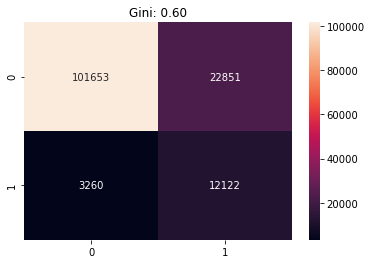

In [83]:
X_train, X_test, y_train, y_test = train_test_split(df.values, data['loan_status'].values, test_size=0.3, random_state=42)

model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

gini = 2*roc_auc_score(y_test, y_pred) - 1
plt.title(f'Gini: {gini:.2f}')
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.show()

## Coefficient scaling

In [84]:
WoE = [0.708396, -0.147986, -0.757155, -0.237045, -0.002945, 0.300903, 0.213164, 0.098333, -0.076295, -0.196744,
      0.200440, -0.062687, -0.337605, 0.235823, 0.062544, -0.055850, -0.203325, -0.619863, 1.283692, -0.850290,
      0.019978, 0.482927, 1.180022, -0.422353, 0.637729, 0.132203, -0.294894, 1.1143, 0.364, -0.05525, -0.395, -0.6785,
      -0.9522, -1.144166, 0.166972, 0.054438, -0.173420, 0.262772, -0.040475, 0.11994, -0.24381, 0.14378, 0.010764, -0.162,
      -0.10833, 0.229417]
beta = model.coef_[0, :]
# min-max scaling coefficients of logistic regression to root out negative values
beta = [(x-min(beta))/max(beta) for x in beta]
alpha = model.intercept_[0]
PDO = 10 # points to double the odds
factor = PDO / math.log(2)
base_score = 500
target_odds = 1
offset = base_score - (factor * math.log(target_odds))
n = len(beta)

# Score_i= (βi × WoE_i + α/n) × Factor + Offset/n
scores = {}
for i, feature in enumerate(df.columns):
    scores[feature] = (beta[i] * WoE[i] + alpha/n)*factor + offset/n
scores

{'int_rate:(5.399, 12.3]': 18.489674035662073,
 'int_rate:(12.3, 19.18]': 8.593255724596624,
 'int_rate:(19.18, 26.06]': -3.9419835947706137,
 'annual_inc:(1895.999, 50000.0]': 8.112707768041151,
 'annual_inc:(50000.0, 78000.0]': 10.79244590577256,
 'annual_inc:(78000.0, 7500000.0]': 16.453011118030044,
 'dti:(-0.001, 11.36]': 13.556632251573753,
 'dti:(11.36, 16.87]': 12.274001944046981,
 'dti:(16.87, 22.78]': 9.568943886450706,
 'dti:(22.78, 39.99]': 7.487688173379712,
 'inq_last_6mths:(-0.002, 0.667]': 13.821487938804328,
 'inq_last_6mths:(0.667, 1.333]': 9.892284594318093,
 'inq_last_6mths:(1.333, 2.0]': 5.597562012488575,
 'revol_util:(-0.001, 39.2]': 14.114778085276054,
 'revol_util:(39.2, 57.6]': 11.8099796035917,
 'revol_util:(57.6, 74.7]': 9.944178799965801,
 'revol_util:(74.7, 892.3]': 7.67031127885324,
 'out_prncp:0': -7.731858732851702,
 'out_prncp:1': 10.83759463558696,
 'total_pymnt:(-0.001, 5552.125]': -12.692815456545055,
 'total_pymnt:(5552.125, 9419.251]': 11.22073017